In [47]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *

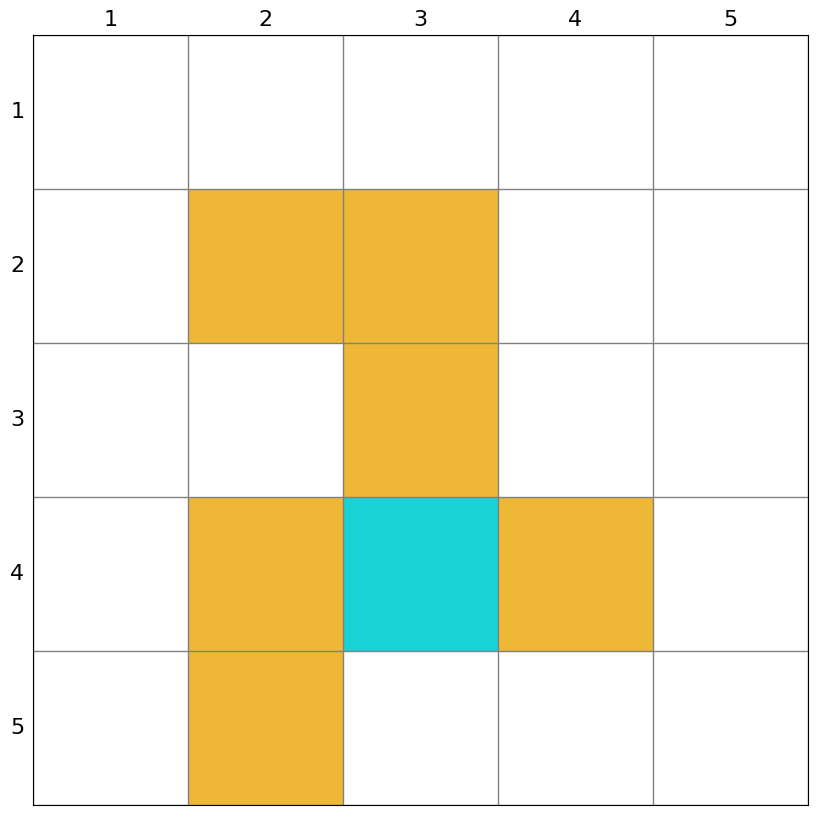

In [48]:
env = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')

In [49]:
def obtain_episode(env, policy, start_state, start_action, length):
        f"""

        :param policy: 由指定策略产生episode
        :param start_state: 起始state
        :param start_action: 起始action
        :param length: episode 长度
        :return: 一个 state,action,reward,next_state,next_action 序列
        """
        env.agent_location = env.state2pos(start_state)
        episode = []
        next_action = start_action
        next_state = start_state
        while length > 0:
            length -= 1
            state = next_state
            action = next_action
            _, reward, done, _, _ = env.step(action)
            next_state = env.pos2state(env.agent_location)
            next_action = np.random.choice(np.arange(len(policy[next_state])),
                                           p=policy[next_state])
            episode.append({"state": state, "action": action, "reward": reward, "next_state": next_state,
                            "next_action": next_action})
        return episode

In [50]:
def MC_basic(env, gamma=0.99, length=100, epochs=5):
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size
    reward_list = env.reward_list
    
    # 初始化策略为均匀分布
    policy = np.ones(shape=(state_space_size, action_space_size)) / action_space_size
    
    # 初始化Q值和访问计数
    qvalue = np.zeros((state_space_size, action_space_size))
    returns_count = np.zeros((state_space_size, action_space_size))  # 记录每个(state, action)的访问次数
    
    for epoch in range(epochs):
            for state in range(state_space_size):
                for action in range(action_space_size):
                    episode = obtain_episode(env, policy, state, action, length)
                    g = 0
                    for step in range(len(episode) - 1, -1, -1):
                        g = episode[step]['reward'] + gamma * g
                    qvalue[state][action] = g
                qvalue_star = qvalue[state].max()
                action_star = qvalue[state].tolist().index(qvalue_star)
                policy[state] = np.zeros(shape=action_space_size)
                policy[state, action_star] = 1
    return policy

In [51]:
policy = MC_basic(env)
print(policy)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


e:\Reinforcement_learning\scripts\render.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


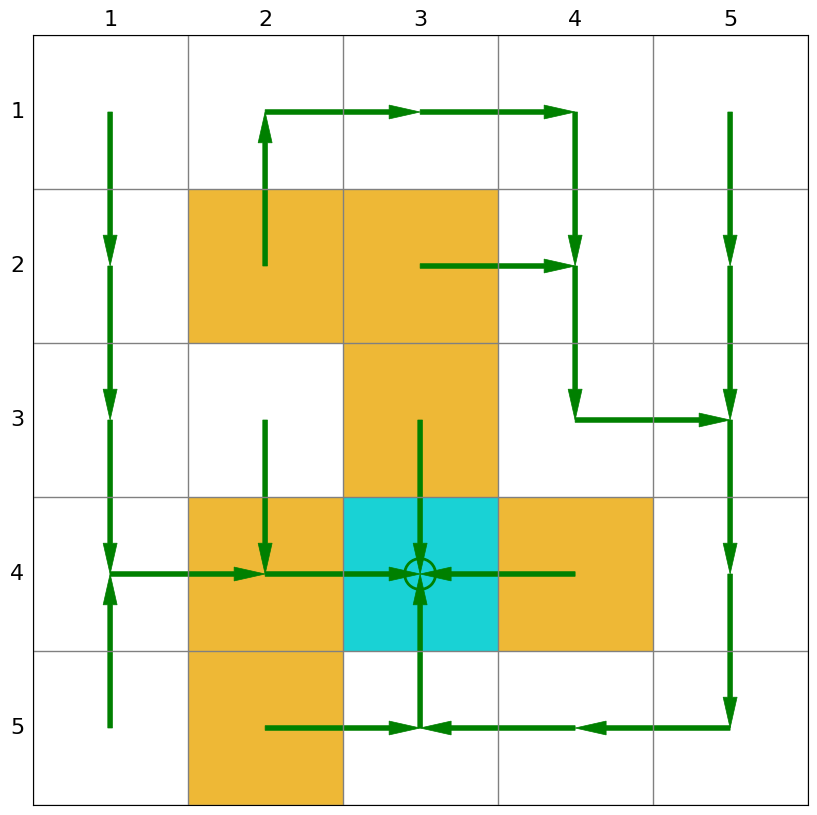

In [52]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy.shape[0]):
    # 计算状态在网格中的位置
    row, col = env.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()